<a href="https://colab.research.google.com/github/nkubana0/FuelTrend/blob/main/Summative_Intro_to_ml_%5BShema_Ivan_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [27]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [28]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
def load_data():
    gasoline_url = "https://prod-energy-fuel-prices.s3.amazonaws.com/wholesalegasolineprices.csv"
    diesel_url = "https://prod-energy-fuel-prices.s3.amazonaws.com/wholesaledieselprices.csv"

    gas_df = pd.read_csv(gasoline_url)
    diesel_df = pd.read_csv(diesel_url)

    gas_df['Date'] = pd.to_datetime(gas_df['Date'], errors='coerce')
    diesel_df['Date'] = pd.to_datetime(diesel_df['Date'], errors='coerce')

    gas_df.rename(columns={
        "Date": "date",
        "Day-of Toronto Wholesale Gasoline  / Prix de gros de l’essence à Toronto": "gasoline_price"
    }, inplace=True)

    diesel_df.rename(columns={
        "Date": "date",
        "Day-of Toronto Wholesale Diesel  / Prix de gros du diesel à Toronto": "diesel_price"
    }, inplace=True)

    df = pd.merge(gas_df[['date', 'gasoline_price']], diesel_df[['date', 'diesel_price']], on='date', how='inner')
    df.dropna(inplace=True)

    # Create a price_category column: 0=low, 1=medium, 2=high
    df['price_mean'] = df[['gasoline_price', 'diesel_price']].mean(axis=1)
    df['price_category'] = pd.qcut(df['price_mean'], q=3, labels=[0,1,2]).astype(int)
    return df

# Feature Engineering

def feature_engineering(df):
    df['gas_minus_diesel'] = df['gasoline_price'] - df['diesel_price']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    return df

# Prepare X and y

def prepare_xy(df, target_column="price_category"):
    X = df.drop(columns=["date", "gasoline_price", "diesel_price", "price_mean", target_column])
    y = df[target_column]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [29]:
def define_model(optimizer='adam', regularizer=None, early_stopping=False, dropout=None, learning_rate=0.001, input_dim=None):
    if isinstance(optimizer, str):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizer))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [30]:
def loss_curve_plot(history):
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

df = load_data()
df = feature_engineering(df)
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['price_category'])
X_train, X_val, y_train, y_val = prepare_xy(train_df)
X_test = test_df.drop(columns=["date", "gasoline_price", "diesel_price", "price_mean", "price_category"])
y_test = test_df["price_category"]

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [31]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_plot(model, X_val, y_val):
    """
    Evaluates the model and plots the accuracy and loss.
    """
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation Loss: {loss:.4f}')
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Predictions for confusion matrix and F1 score
    y_pred_prob = model.predict(X_val)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # F1 Score
    f1 = f1_score(y_val, y_pred, average='weighted') # Use weighted for multiclass
    print(f"F1 Score: {f1:.4f}")

    # You can add plotting for accuracy here if needed, similar to loss_curve_plot
    # For example, to show training vs validation accuracy
    # if history is passed to this function as well.

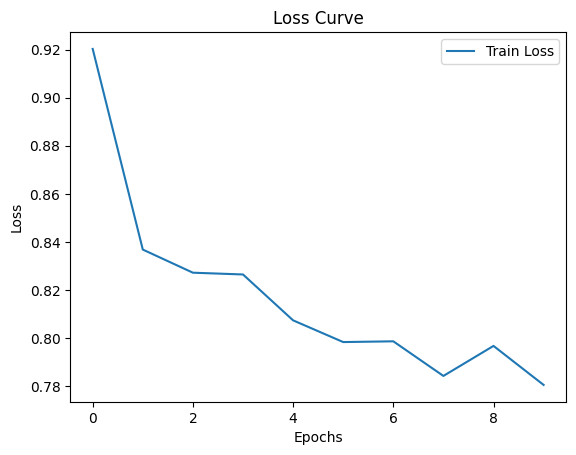

Validation Loss: 0.8456
Validation Accuracy: 0.6017
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix:


[[50 20  9]
 [24 40 15]
 [10 16 52]]
F1 Score: 0.6013


In [32]:
#TODO:
model1 = define_model(input_dim=X_train.shape[1])
hist1 = model1.fit(X_train, y_train, epochs=10, verbose=0)
loss_curve_plot(hist1)
evaluate_model_plot(model1, X_val, y_val)
model1.save("saved_models/model1.h5")

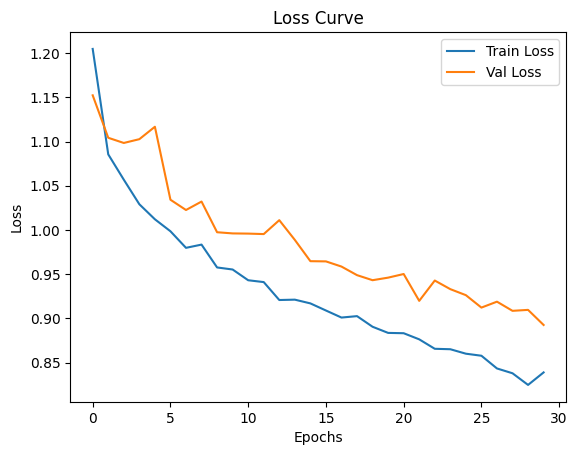

Validation Loss: 0.8927
Validation Accuracy: 0.6483
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Confusion Matrix:
[[52 20  7]
 [18 51 10]
 [ 7 21 50]]
F1 Score: 0.6508


In [33]:
#TODO:
model2 = define_model(
    optimizer='adam',
    regularizer=regularizers.l2(0.001),
    dropout=0.2,
    input_dim=X_train.shape[1]
)
hist2 = model2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)
loss_curve_plot(hist2)
evaluate_model_plot(model2, X_val, y_val)
model2.save("saved_models/model2.h5")

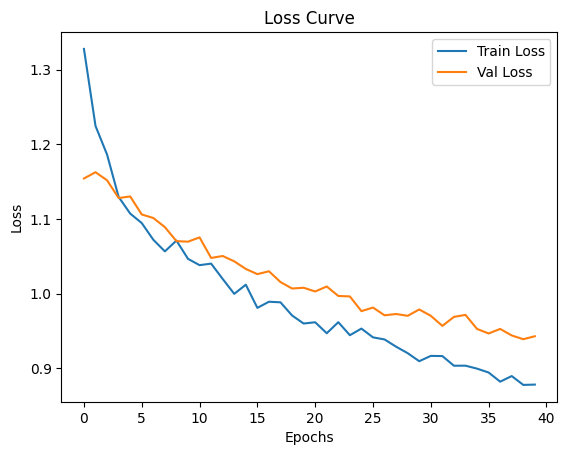

Validation Loss: 0.9431
Validation Accuracy: 0.6059
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Confusion Matrix:
[[48 24  7]
 [20 50  9]
 [ 5 28 45]]
F1 Score: 0.6104


In [34]:
#TODO:
model3 = define_model(
    optimizer='rmsprop',
    regularizer=regularizers.l2(0.001),
    dropout=0.3,
    learning_rate=0.0005,
    input_dim=X_train.shape[1]
)
hist3 = model3.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), verbose=0)
loss_curve_plot(hist3)
evaluate_model_plot(model3, X_val, y_val)
model3.save("saved_models/model3.h5")

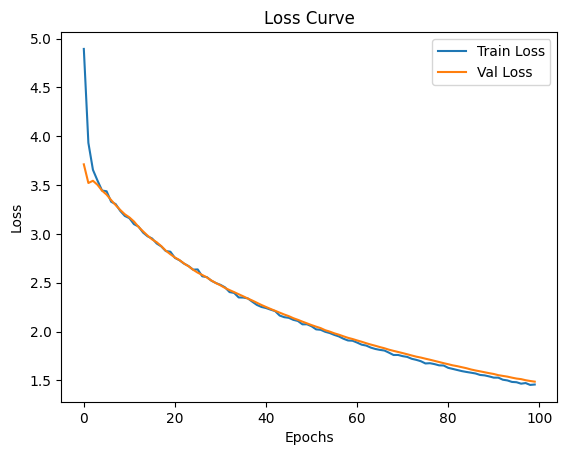

Validation Loss: 1.4870
Validation Accuracy: 0.5847
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Confusion Matrix:
[[49 18 12]
 [19 36 24]
 [ 6 19 53]]
F1 Score: 0.5828


In [35]:
#TODO:
es = EarlyStopping(monitor='val_loss', patience=5)
model4 = define_model(
    optimizer='adam',
    regularizer=regularizers.l2(0.01),
    dropout=0.4,
    learning_rate=0.0001,
    input_dim=X_train.shape[1]
)
hist4 = model4.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
loss_curve_plot(hist4)
evaluate_model_plot(model4, X_val, y_val)
model4.save("saved_models/model4.h5")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Final Evaluation on Test Set
Accuracy: 0.583732057416268
Precision: 0.5744539411206078
Recall: 0.5847481021394065
F1 Score: 0.5728620484960514


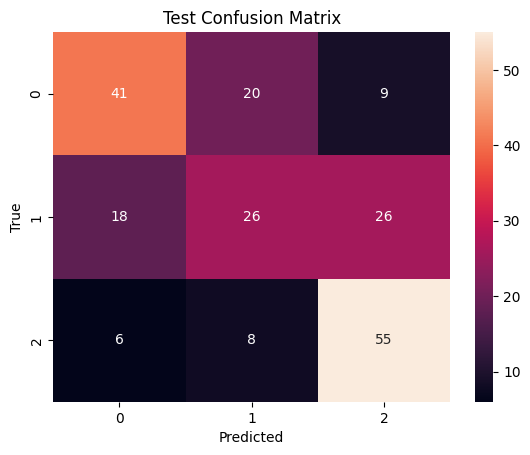

In [36]:
def make_predictions(model_path, X):
    model = load_model(model_path)
    probs = model.predict(X)
    preds = np.argmax(probs, axis=1)
    return preds

best_model_path = "saved_models/model4.h5"
test_preds = make_predictions(best_model_path, X_test)

# Final evaluation
print("Final Evaluation on Test Set")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds, average='macro'))
print("Recall:", recall_score(y_test, test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, test_preds, average='macro'))
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d')
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [37]:
model_path = best_model_path # Use the path to the best model determined earlier
make_predictions(model_path, X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([2, 1, 1, 2, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0,
       1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 1, 0, 0,
       2, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 2, 1, 1, 2, 2,
       0, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 0, 0,
       2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 0,
       0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0,
       2, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1, 0,
       2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 0, 2, 0,
       1, 0, 2, 0, 1, 1, 2, 2, 1, 1, 0])

Congratulations!!
